Goal of this analysis is to explore Robomission tasks and decide on reasonable levels. Each level is a group of tasks, which should be coherent, in the sense of being of similar overall difficulty, having same set of prerequisities (concepts which should be already known to the student) and having a unifying element translated into a descriptive name of the level.

In [56]:
from collections import Counter, OrderedDict
from itertools import product
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

# ad-hoc imports
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.adjust_text import adjust_text

In [3]:
# load data (hack)
sys.path.append(os.path.abspath(os.path.join('..', 'data', 'robomission')))
from tasks_2017_09_25 import tasks

In [88]:
# helper functions

def get_letters(task):
    """Return all letters (= objects) in the setting of a task"""
    letters = Counter()
    fields = task.setting['fields']
    for row in fields:
        for _background, objects in row:
            letters.update(canonize(objects))
    return letters


def get_special_color_count(task):
    fields = task.setting['fields']
    colors = set()
    for row in fields:
        for background, _objects in row:
            colors.add(background)
    return len(colors) - 2  # don't count black and blue


def canonize(letters):
    # canonize wormhole names
    letters = ['W' if letter in 'XYZ' else letter for letter in letters]
    return letters


def _get_all_letters():
    """Return set of all letters appearing in at least one task
    
    Ignores letters appearing in all tasks (they are not informative)
    """
    letter_sets = [set(get_letters(task)) for task in tasks]
    letters_in_some_tasks = set.union(*letter_sets)
    letters_in_all_tasks = set.intersection(*letter_sets)
    return letters_in_some_tasks - letters_in_all_tasks

ALL_LETTERS = list(sorted(_get_all_letters()))



def _get_tokens_counts(ast, inside_loop=False):
    """Return a counter of all tokens (~ blockly blocks) in given RoboAST
    """
    # TODO: unhack, allow for and/or
    if not ast:
        return Counter()
    if 'statement' in ast:
        return _get_tokens_counts(ast['statement'], inside_loop)
    tokens = Counter([ast['head']])
    if inside_loop and ast['head'] in {'repeat', 'while'}:
        tokens['nestedL'] += 1
    if 'test' in ast:
        tokens[ast['test']['head']] += 1
    next_statements = ast['body'] if 'body' in ast else []
    if 'orelse' in ast and ast['orelse'] is not None:
        next_statements.append(ast['orelse'])
    inside_loop = inside_loop or ast['head'] in {'repeat', 'while'}
    for statement in next_statements:
        tokens.update(_get_tokens_counts(statement, inside_loop))
    return tokens


def get_solution_tokens_counts(task):
    return _get_tokens_counts(task.solution)


def _get_all_solution_tokens():
    """Return set of all tokens appearing in at least one task
    
    Ignores tokens appearing in all tasks (they are not informative)
    """
    token_sets = [set(get_solution_tokens_counts(task)) for task in tasks]
    tokens_in_some_tasks = set.union(*token_sets)
    tokens_in_all_tasks = set.intersection(*token_sets)
    return tokens_in_some_tasks - tokens_in_all_tasks

ALL_TOKENS = _get_all_solution_tokens()


def get_level(task, norm=True):
    levels = {
        'moves': 1,
        'world': 2,
        'repeat': 3,
        'while': 4,
        'loops': 5,
        'if': 6,
        'comparing': 7,
        'if-else': 8,
        'final-challenge': 9
    }
    level = levels[task.category_id]
    return level/9 if norm else level


def get_color(task):
    cm = plt.get_cmap('viridis')
    colors = {
        'moves': cm.colors[0],
        'world': cm.colors[32],
        'repeat': cm.colors[32 * 2],
        'while': cm.colors[32 * 3],
        'loops': cm.colors[32 * 4],
        'if': cm.colors[32 * 5],
        'comparing': cm.colors[32 * 6],
        'if-else': cm.colors[32 * 7],
        'final-challenge': cm.colors[32 * 8 - 1]
    }
    return colors[task.category_id]

# info:
print('ALL_LETTERS:', ALL_LETTERS)
print('ALL_TOKENS:', ALL_TOKENS)

# feature extractors

def get_setting_features(task):
    letter_counts = get_letters(task)
    features = OrderedDict([
        (letter, letter_counts[letter])
        for letter in ALL_LETTERS
    ])
    features['yrg'] = get_special_color_count(task)
    features['limit'] = task.setting.get('length', 0)
    features['energy'] = task.setting.get('energy', 0)
    return features


def get_solution_features(task):
    token_counts = get_solution_tokens_counts(task)
    features = {
        token: token_counts[token]
        for token in ALL_TOKENS
    }
    return features


def get_features_for_task(task):
    """Compute features for a given task.
    """
    features = OrderedDict()
    features.update(get_setting_features(task))
    features.update(get_solution_features(task))
    return features


def shorten(name):
    parts = name.split('-')
    parts[1:] = [part[0] for part in parts[1:]]
    return '-'.join(parts)
    #return name[:10]

# precompute all features
RAW_FEATURES = pd.DataFrame.from_records([get_features_for_task(task) for task in tasks])
SETTING_FEATURES = ['A', 'M', 'D', 'W', 'yrg', 'limit', 'energy']
SOLUTION_FEATURES = ['fly', 'left', 'right', 'shoot', 'repeat', 'while', 'nestedL', 'if', 'else', 'color', 'position']
RAW_FEATURES.head()

ALL_LETTERS: ['A', 'D', 'M', 'W']
ALL_TOKENS: {'repeat', 'color', 'fly', 'while', 'shoot', 'right', 'left', 'else', 'if', 'nestedL', 'position'}


,A,D,M,W,yrg,limit,energy,else,repeat,shoot,right,left,fly,if,position,while,nestedL,color
0,8,0,0,0,1,4,0,0,0,0,0,1,1,0,0,2,0,2
1,2,7,2,2,0,0,2,0,4,2,1,3,2,0,0,0,0,0
2,0,9,0,2,0,4,0,0,0,0,1,0,1,1,1,1,0,1
3,18,0,4,0,0,3,4,0,0,1,0,0,1,0,0,1,0,1
4,0,6,0,2,0,4,0,21,0,0,1,21,0,1,1,1,0,1


In [70]:
def get_feature_df(which_features='setting+solution', transform='bin'):
    """Create a DataFrame with selected and transformed featrues.
    
    Args:
        features:
            'setting': to include setting features only
            'solution': to include solution features only
            'setting+solution': to include all features
        transform:
            'bin' to binarize features,
            'log' to logaritmize them,
            'z-score' to z-normalize them
            None: no transform (full counts/numbers)        
    """
    # select features
    feature_names = []
    if 'setting' in which_features.split('+'):
        feature_names += SETTING_FEATURES
    if 'solution' in which_features.split('+'):
        feature_names += SOLUTION_FEATURES        
    features = RAW_FEATURES[feature_names].copy()    
    # apply transformations
    if 'log' in transform.split('+'):
        features = features.apply(lambda s: np.log(s + 1))
    if 'bin' in transform.split('+'):
        features = features.apply(lambda s: 0 + (s > 0))
    if 'zscore' in transform.split('+'):
        features = features.apply(lambda s: (s - s.mean())/s.std(ddof=0))
    if 'range' in transform.split('+'):
        features = features.apply(lambda s: s / s.max()) 
    return features

# examples:
setting_features = get_feature_df(which_features='setting', transform='bin')
solution_features = get_feature_df(which_features='solution', transform='bin')
all_features = get_feature_df(which_features='setting+solution', transform='bin')
all_features.head()

,A,M,D,W,yrg,limit,energy,fly,left,right,shoot,repeat,while,nestedL,if,else,color,position
0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0
1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0
2,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1
3,1,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0
4,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1


We will compare two approaches: computing level as the weighted sum of features and as a most difficult concept used.

In [129]:
f = all_features
level = (
    0
    + 0.25 * f.fly
    + 0.25 * f.left
    + 0.25 * f.right
    + 0.5 * f.shoot
    + 1.0 * f.repeat
    + 1.0 * f['while']
    + 1.0 * f.nestedL
    + 0.5 * f.color
    + 0.5 * f.position
    + 1.0 * f['if']
    + 1.0 * f['else']
    + 0.1 * f.A
    + 0.1 * f.M
    + 0.2 * f.D
    + 0.3 * f.W
    + 0.1 * f.yrg
    + 0.3 * f.limit
    + 0.3 * f.energy
)
level.describe()

count    57.000000
mean      3.099123
std       1.617910
min       0.250000
25%       2.000000
50%       3.000000
75%       4.300000
max       6.150000
dtype: float64

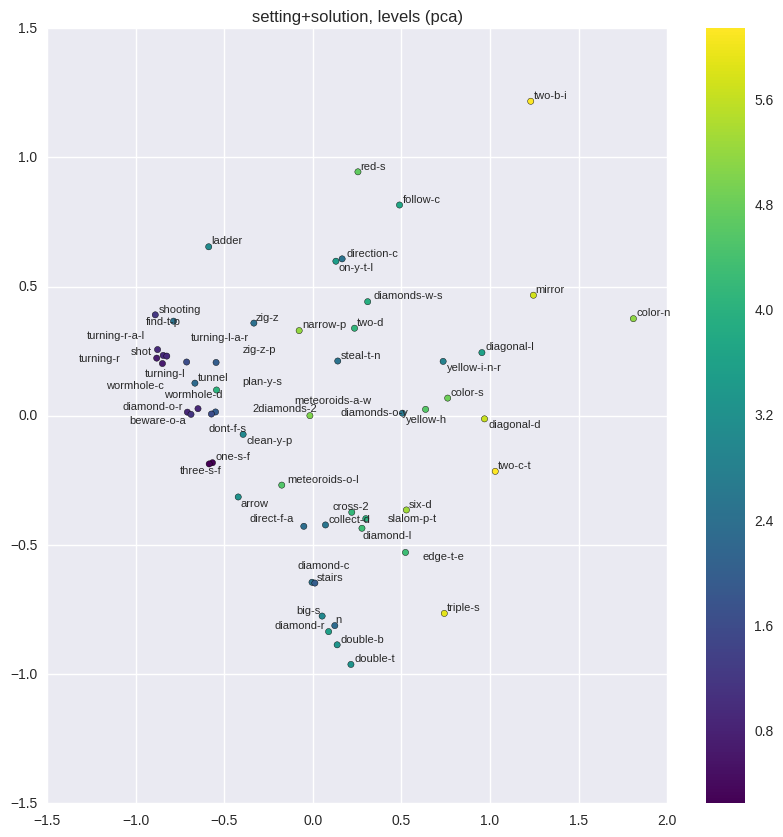

In [131]:
def create_model(name):
    if name == 'pca':
        return PCA(n_components=2)
    if name == 'tsne':
        return TSNE(perplexity=30, learning_rate=200, n_iter=5000)
    raise ValueError('Unknown model name "{name}"'.format(name=name))
    
def project(features, model='pca', label='', colors=None, label_fn=None):    
    title = '{label} ({model})'.format(label=label, model=model)
    model = create_model(name=model)
    emb = pd.DataFrame(model.fit_transform(features))                       
    plt.figure(figsize=(10, 10))
    n = len(emb)
    x = emb[0] + np.random.normal(scale=0.01, size=n)
    y = emb[1] + np.random.normal(scale=0.01, size=n)
    #colors = [get_level(task, norm=True) for task in tasks]
    plt.scatter(x, y, c=colors, cmap=plt.get_cmap('viridis'))
    label_fn = label_fn or (lambda i: shorten(tasks[i].task_id))
    labels = [plt.text(x[i], y[i], label_fn(i) , size=8) for i in range(n)]
    adjust_text(labels, limit=200, precision=0.5)
    plt.title(title)
    plt.colorbar()
    plt.show()
    return model

features = get_feature_df(which_features='setting+solution', transform='log+range')
model = project(features, model='pca', label='setting+solution, levels', colors=level)

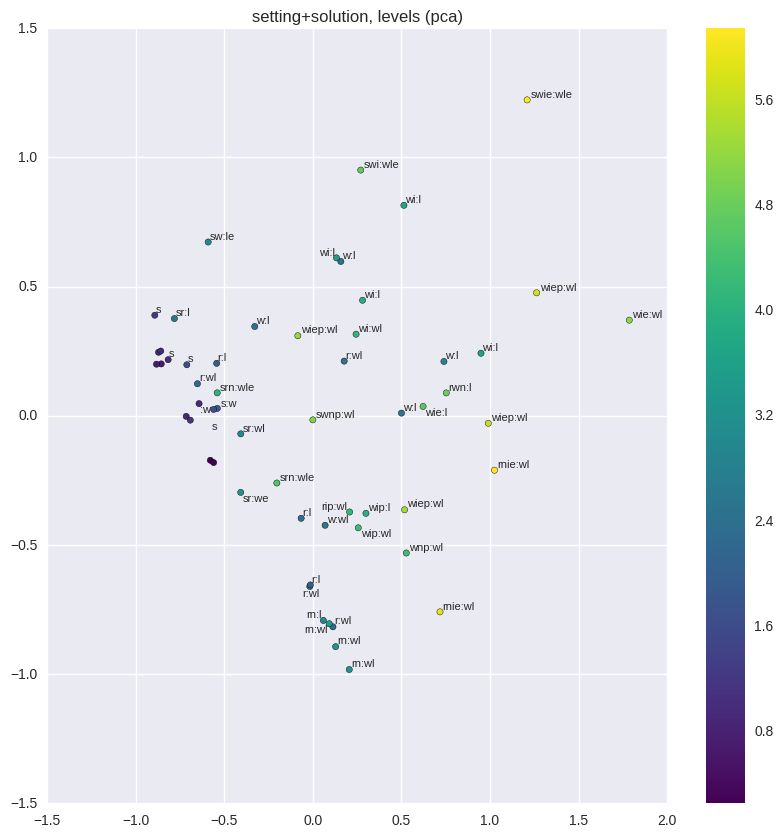

In [133]:
def get_features_label(i):
    features = set(f for f, c in get_features_for_task(tasks[i]).items() if c > 0)
    setting_symbols = [f[0].lower() for f in SETTING_FEATURES
                       if f in features and f not in {'A', 'M', 'D', 'yrg'}]
    solution_symbols = [f[0] for f in SOLUTION_FEATURES
                        if f in features and f not in {'fly', 'left', 'right', 'color'}]
    label = ''.join(solution_symbols)
    if setting_symbols:
        label += ':' + ''.join(setting_symbols) 
    return label
    
model = project(features, model='pca', label='setting+solution, levels',
                colors=level, label_fn=get_features_label)

We will explore groups with the following iterative procedure: start with a group of tasks with a single concept, each new group introduces at most 1 new concept.

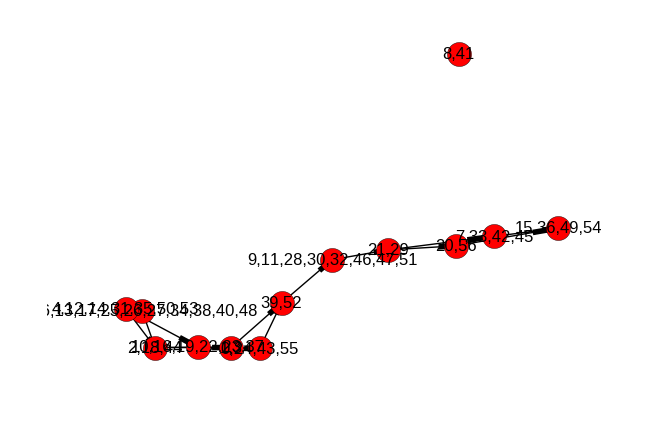

In [190]:
def filter_tasks_covered_by_features(tasks, feature_set):
    covered = tasks.drop(list(feature_set), axis=1).sum(axis=1) == 0
    return tasks[covered], tasks[-covered]


def create_level_graph(tasks):
    g = nx.Graph()
    feature_set = {'fly'}
    covered, uncovered = filter_tasks_covered_by_features(tasks, feature_set)

def get_label(tasks):
    return ','.join(str(i) for i in tasks.index)

# TODO: automatic exploration of nodes
# TODO: draw labels on edges (diff between feature sets)
# TODO: better decision on when to draw an edge
# TODO: micro-language for specifying features
# TODO: nicer graph drawing
feature_sets = [
    {'fly'},
    {'fly', 'left', 'right', 'A', 'M'},
    {'fly', 'left', 'right', 'shoot', 'A', 'M'}, # TODO: or diamonds first? (how to explore both options?)
    {'fly', 'left', 'right', 'shoot', 'A', 'M', 'D'},
    {'fly', 'left', 'right', 'shoot', 'A', 'M', 'D', 'W'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'A', 'M', 'D', 'W', 'limit'},  # or while first
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'A', 'M', 'D', 'W', 'limit'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'A', 'M', 'D', 'W', 'limit', 'yrg'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'A', 'M', 'D', 'W', 'limit', 'yrg', 'energy'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'if', 'A', 'M', 'D', 'W', 'limit', 'yrg', 'energy'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'if', 'position',
     'A', 'M', 'D', 'W', 'limit', 'yrg', 'energy'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'if', 'position', 'else',
     'A', 'M', 'D', 'W', 'limit', 'yrg', 'energy'},
    {'fly', 'left', 'right', 'shoot', 'repeat', 'while', 'color', 'if', 'position', 'else', 'nestedL',
     'A', 'M', 'D', 'W', 'limit', 'yrg', 'energy'},
]
node_labels = []
g = nx.DiGraph()
uncovered = get_feature_df(which_features='setting+solution', transform='bin')
for i, feature_set in enumerate(feature_sets):
    covered, uncovered = filter_tasks_covered_by_features(uncovered, feature_set)
    label = get_label(covered)
    g.add_node(label)
    node_labels.append(label)
    for j in range(0, i):
        diff = feature_set - feature_sets[j]
        if len(diff) < 3:
            g.add_edge(label, node_labels[j])
nx.draw(g, with_labels=True)

In [153]:
d, u = filter_tasks_covered_by_features(tasks, ['fly'])

In [157]:
','.join(str(i) for i in u.index)

'0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56'

In [168]:
g.nodes

NodeView(('w', '?'))

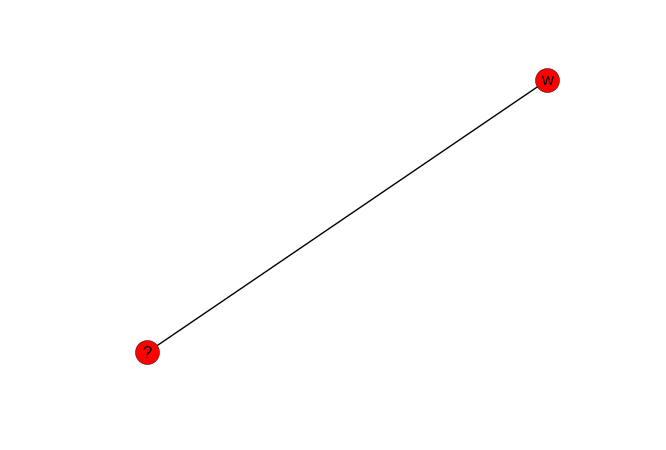

In [163]:
g = nx.Graph()
g.add_node('?')
g.add_node('w')
g.add_edge('w', '?')
nx.draw(g, with_labels=True)

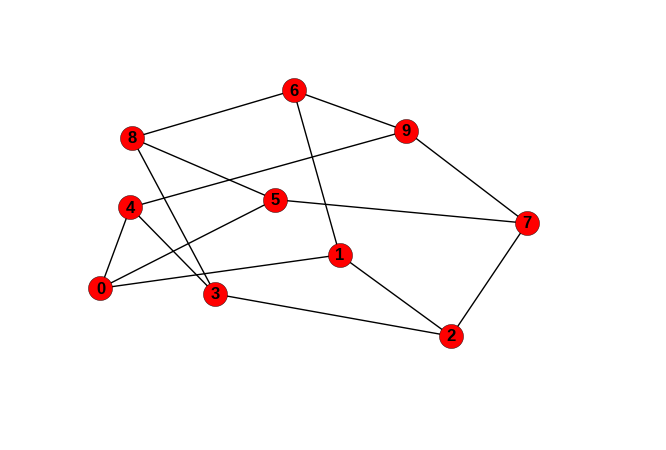

In [58]:
G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')